In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt



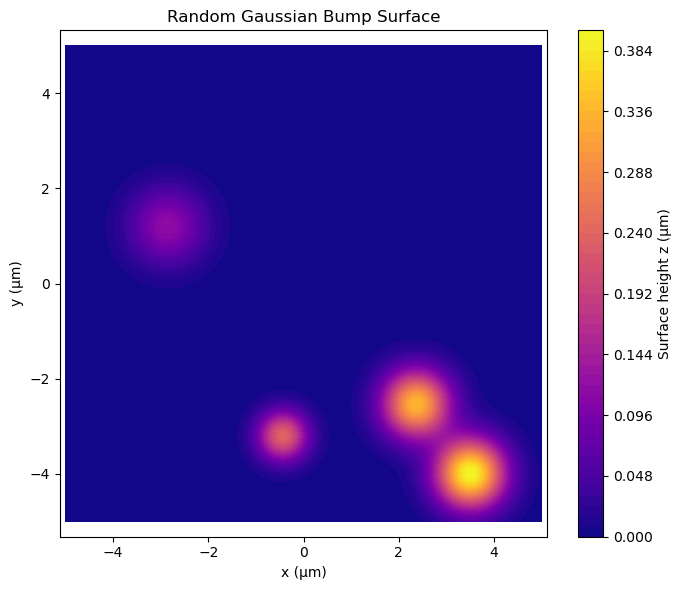

In [2]:
# Re-run and add CSV export of bump parameters
import pandas as pd

# Grid for surface
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

np.random.seed(42)  # for reproducibility

# Generate random bump parameters
num_bumps = np.random.randint(2, 5)
bump_data = []

for i in range(num_bumps):
    x0 = np.random.uniform(-4, 4)
    y0 = np.random.uniform(-4, 4)
    height = np.random.uniform(0.1, 0.4)
    sigma = np.random.uniform(0.2, 0.7)

    bump = height * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
    Z += bump

    bump_data.append({
        "bump_id": i,
        "x0": x0,
        "y0": y0,
        "height": height,
        "sigma": sigma
    })

# Optional base level (like a flat substrate)
Z -= 0

# Export bump parameters to CSV
bump_df = pd.DataFrame(bump_data)
csv_path = "/mnt/c/Users/tripl/OneDrive - Danmarks Tekniske Universitet/Speciale/bioscat3d/MeepTests/dataDump.csv"  # Provide download path
bump_df.to_csv(csv_path, index=False)

# Plot the surface
plt.figure(figsize=(7, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='plasma')
plt.colorbar(contour, label="Surface height z (μm)")
plt.title("Random Gaussian Bump Surface")
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [3]:
# Simulation parameters
resolution = 10 # pixels/um
pml_thickness = 2
dim = 10
cell_x = dim
cell_y = dim
cell_z = dim

sphere_radius = 1.0
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

# Plane wave incidence defined by polar and azimuthal angles (in degrees)
theta_deg = 1  # Polar angle from +Z
phi_deg = 0    # Azimuthal angle in x–y plane

# Convert to radians
theta = np.radians(theta_deg)
phi = np.radians(phi_deg)

# Build normalized k-vector
k_unit = mp.Vector3(
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    -np.cos(theta)  # negative for downward propagation
)

# Scale for Meep's eig_kpoint (|k| = frequency in Meep units)
eig_kpoint = k_unit.scale(frequency)



In [4]:
# Materials
substrate_material = mp.Medium(epsilon=substrate_eps)
#def bump_material(p):
#    bump_height = 0.3 * np.exp(-((p.x)**2 + (p.y)**2) / 0.2**2)
#    z_surface = -0.5 + bump_height
#    return substrate_material if p.z < z_surface else mp.air

# Define bump surface: z = -0.5 + bump_height
def bump_material(p):
    bump_height = 0.3 * np.exp(-(p.x**2 + p.y**2) / 0.2**2)
    z_surface = -0.5 + bump_height
    return substrate_material if p.z < z_surface else mp.air




# Source: downward plane wave at angles
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=mp.Vector3(cell_x, cell_y, 0),
        direction=mp.Z,  # still Z, but mode defines propagation
        eig_kpoint=eig_kpoint,
        eig_band=1,
        eig_match_freq=True
    )
]


# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources, # you can still add discrete objects
    default_material=bump_material
)


# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}

# Run the simulation
sim.run(until=60)


-----------
Initializing structure...
time for choose_chunkdivision = 0.00113583 s
Working in 3D dimensions.
Computational cell is 10 x 10 x 10 with resolution 10
time for set_epsilon = 29.3515 s
-----------
MPB solved for frequency_1(0.0174524,0,-0.999848) = 1 after 81 iters
Meep progress: 1.6/60.0 = 2.7% done in 4.0s, 146.2s to go
on time step 32 (time=1.6), 0.12514 s/step
Meep progress: 6.15/60.0 = 10.3% done in 8.0s, 70.2s to go
on time step 123 (time=6.15), 0.0440417 s/step
Meep progress: 10.75/60.0 = 17.9% done in 12.0s, 55.1s to go
on time step 215 (time=10.75), 0.0436379 s/step
Meep progress: 15.5/60.0 = 25.8% done in 16.0s, 46.0s to go
on time step 310 (time=15.5), 0.0421479 s/step
Meep progress: 20.150000000000002/60.0 = 33.6% done in 20.0s, 39.6s to go
on time step 403 (time=20.15), 0.0430552 s/step
Meep progress: 24.85/60.0 = 41.4% done in 24.1s, 34.1s to go
on time step 497 (time=24.85), 0.0429558 s/step
Meep progress: 29.5/60.0 = 49.2% done in 28.1s, 29.1s to go
on time s

In [5]:
def plot_field_slice(abs_E, axis='y', index=None, projection=False,
                     extent=None, cmap='inferno', title=None):
    """
    Plot a 2D slice or projection of a 3D field magnitude array.

    Parameters:
    - abs_E: 3D numpy array (e.g., shape [x, y, z])
    - axis: 'x', 'y', or 'z' — axis to slice or project along
    - index: index for slicing (ignored if projection=True)
    - projection: if True, show max intensity projection along axis
    - extent: tuple (xmin, xmax, ymin, ymax) for plot scaling
    - cmap: colormap name
    - title: plot title
    """

    axis_dict = {'x': 0, 'y': 1, 'z': 2}
    ax = axis_dict[axis]

    if projection:
        slice_2d = np.max(abs_E, axis=ax)
        label = f'Max projection along {axis.upper()}'
    else:
        if index is None:
            index = abs_E.shape[ax] // 2
        slicer = [slice(None)] * 3
        slicer[ax] = index
        slice_2d = abs_E[tuple(slicer)]
        label = f'Slice at {axis.upper()} = {index}'

    # Transpose for proper orientation (so x is horizontal, z vertical)
    if ax == 0:  # x-slice → show y-z
        extent = extent or [-1, 1, -1, 1]
        xlabel, ylabel = 'y (µm)', 'z (µm)'
        slice_2d = slice_2d.T
    elif ax == 1:  # y-slice → show x-z
        extent = extent or [-1, 1, -1, 1]
        xlabel, ylabel = 'x (µm)', 'z (µm)'
        slice_2d = slice_2d.T
    elif ax == 2:  # z-slice → show x-y
        extent = extent or [-1, 1, -1, 1]
        xlabel, ylabel = 'x (µm)', 'y (µm)'

    plt.figure(dpi=100)
    plt.imshow(slice_2d, cmap=cmap, origin='lower', extent=extent)
    plt.colorbar(label='|E|')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title or label)
    plt.show()


Flux through top: 33.951853
Flux through bottom: -366.334705
Flux through left: 9.466956
Flux through right: -0.609009
Flux through front: 4.204980
Flux through back: -5.635600
Flux through top: 33.951853
Flux through bottom: -366.334705
Flux through left: 9.466956
Flux through right: -0.609009
Flux through front: 4.204980
Flux through back: -5.635600


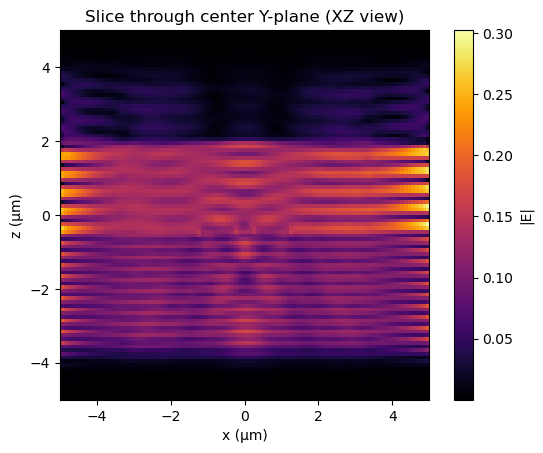

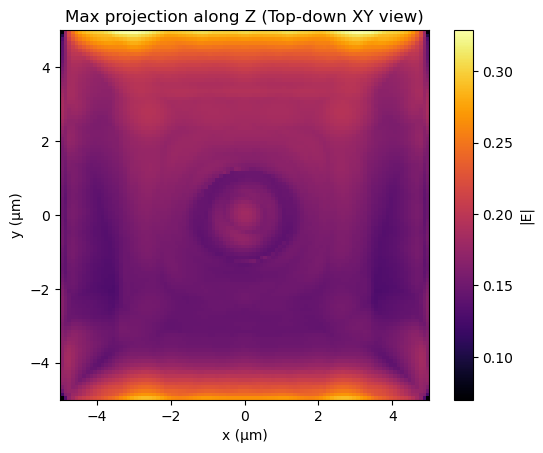

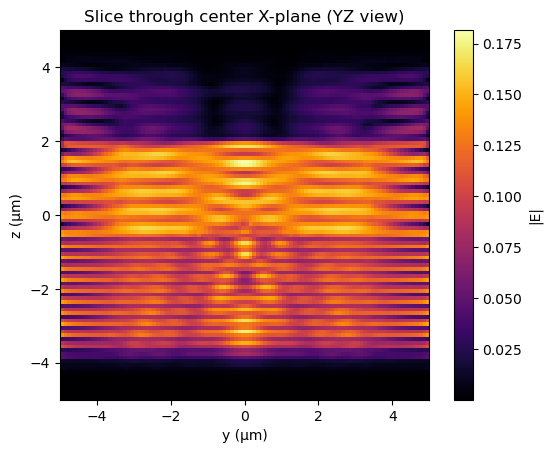

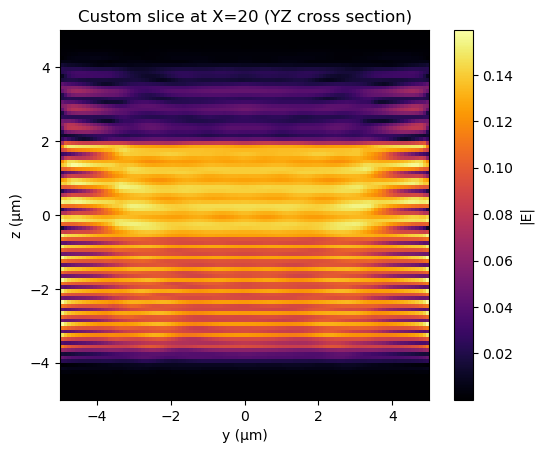

In [6]:
# Print flux values
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# Assume abs_E is shape (160, 12, 160) → (x, y, z)

# Full 3D array extraction
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ez)

# Total magnitude
abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)


# === Print total flux through each monitor ===
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# === Full 3D Electric Field Extraction ===
# Assume simulation has finished and fields are stored in the simulation domain

# Extract Ex, Ey, Ez components from the full cell
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ez)

# Compute total electric field magnitude |E| = sqrt(Ex² + Ey² + Ez²)
abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

# Optional: save field for later reuse
np.save("abs_E.npy", abs_E)


# === Plot 1: Slice through the middle of the domain in Y (XZ plane) ===
# This is the standard side view showing the wave propagating in the XZ plane
# Ideal for verifying the angle of incidence and interaction with the bump
plot_field_slice(
    abs_E,
    axis='y',
    index=abs_E.shape[1] // 2,
    extent=[-cell_x/2, cell_x/2, -cell_z/2, cell_z/2],
    title="Slice through center Y-plane (XZ view)"
)


# === Plot 2: Max projection along Z (XY top-down view) ===
# Shows the max |E| encountered along the height of the structure.
# Useful for identifying horizontal spreading, bump effects, and hot spots
plot_field_slice(
    abs_E,
    axis='z',
    projection=True,
    extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2],
    title="Max projection along Z (Top-down XY view)"
)


# === Plot 3: Slice through the middle of the domain in X (YZ plane) ===
# This shows the vertical field interaction when viewed from the side along Y.
# Can be helpful for symmetry checks in the other direction.
plot_field_slice(
    abs_E,
    axis='x',
    index=abs_E.shape[0] // 2,
    extent=[-cell_y/2, cell_y/2, -cell_z/2, cell_z/2],
    title="Slice through center X-plane (YZ view)"
)


# === Plot 4: Optional Custom Slice at X=20 (cross section across bump) ===
# Allows inspection of field behavior on one side of the bump
x_index = 20
if x_index < abs_E.shape[0]:
    plot_field_slice(
        abs_E,
        axis='x',
        index=x_index,
        extent=[-cell_y/2, cell_y/2, -cell_z/2, cell_z/2],
        title=f"Custom slice at X={x_index} (YZ cross section)"
    )
else:
    print(f"Custom X slice index {x_index} exceeds bounds ({abs_E.shape[0]}). Skipped.")



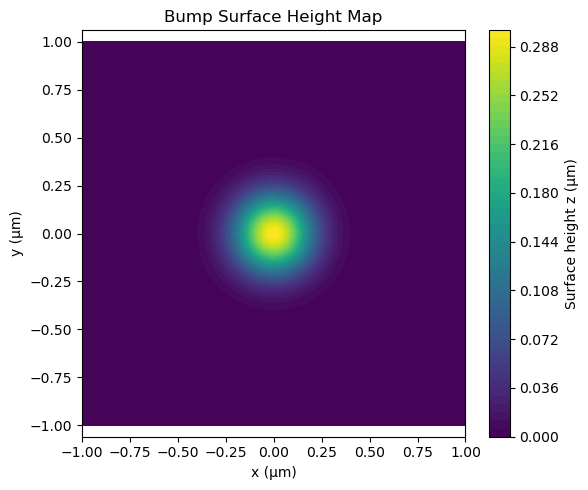

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid for x and y
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)

# Define bump surface: z = -0.5 + bump_height
bump_height = 0.3 * np.exp(-(X**2 + Y**2) / 0.2**2)
Z = bump_height

# 2D contour plot
plt.figure(figsize=(6, 5))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='Surface height z (μm)')
plt.title('Bump Surface Height Map')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.axis('equal')
plt.tight_layout()
plt.show()
